In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates

In [3]:
cd .. 

c:\Users\alaurent\source\repos\montinette


In [128]:
from montinette.sensors import CounterDataFrame, count_veh_in_spot

In [157]:
df = pd.read_csv('./input/capteurs/116/116_bi_directionnel.csv', sep=';')
df['id'] = '116'

cdf_in = CounterDataFrame(
    df,
    datetime='Timestamp',
    counter='eventsCountA',
    name='id',
    timestamp=True,
    #timezone='America/Montreal'
)
cdf_out = CounterDataFrame(
    df,
    datetime='Timestamp',
    counter='eventsCountB',
    name='id',
    timestamp=True,
    #timezone='America/Montreal'
)
cout = cdf_out.get_counts('15T')
cin = cdf_in.get_counts('15T')
spot_116 = count_veh_in_spot(cin, cout, reset_interval=1)
spot_116.assign(timestamp=lambda x: x.timestamp.dt.tz_localize(None)).to_excel('./output/stationnement_116.xlsx')

Resets in counts have been detected. Column "reset" created.
Resets in counts have been detected. Column "reset" created.


In [171]:
# Data from all sensors
import os

directory = os.fsencode('./input/capteurs/117/')
    
data = []
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     data.append(pd.read_csv(os.path.join(os.fsdecode(directory), filename), sep=';'))

df = pd.concat(data)
df = df.drop_duplicates()

In [172]:
# Divide data by sensors type
## Sensors for the vehicules which went in the parking lot
cdf_in = CounterDataFrame(
    df[df['Entity Name'] == '034050780000000A'].copy(),
    datetime='Timestamp',
    counter='eventsCountA',
    name='Entity Name',
    timestamp=True
)

cdf_out = CounterDataFrame(
    df[df['Entity Name'] == '034050780000000B'].copy(), 
    datetime='Timestamp', 
    counter='eventsCountB', 
    name='Entity Name', 
    timestamp=True
)

interval_reset = 1

# Compute the hourly counts IN/OUT
cout = cdf_out.get_counts('15T')
#cout2 = cdf_out_2.get_counts('1H')
cin = cdf_in.get_counts('15T')
#cin2 = cdf_in_2.get_counts('1H')
spot_117 = count_veh_in_spot(cin, cout, reset_interval=1)

Resets in counts have been detected. Column "reset" created.
Resets in counts have been detected. Column "reset" created.


In [145]:
spot_117.assign(timestamp=lambda x: x.timestamp.dt.tz_localize(None)).to_excel('./output/stationnement_117.xlsx')

### Plotting

In [173]:
ct_in_out = spot_117.copy()
ct_in_out['date'] = ct_in_out.timestamp.dt.date
ct_in_out['hr'] = ct_in_out.timestamp.dt.hour
ct_in_out = ct_in_out.reset_index().assign(date=lambda x: pd.to_datetime(x.date)).set_index(['date', 'hr'])

In [175]:
import datetime

dt_from='2023-06-01'
dt_to='2023-06-30'
data = ct_in_out[dt_from:dt_to][['in', 'out', 'delta', 'nb_veh']].copy()
data['charge'] = data.nb_veh
data = data.reset_index()
data['timestamp'] = data.date + data.hr.apply(lambda x: datetime.timedelta(hours=x))

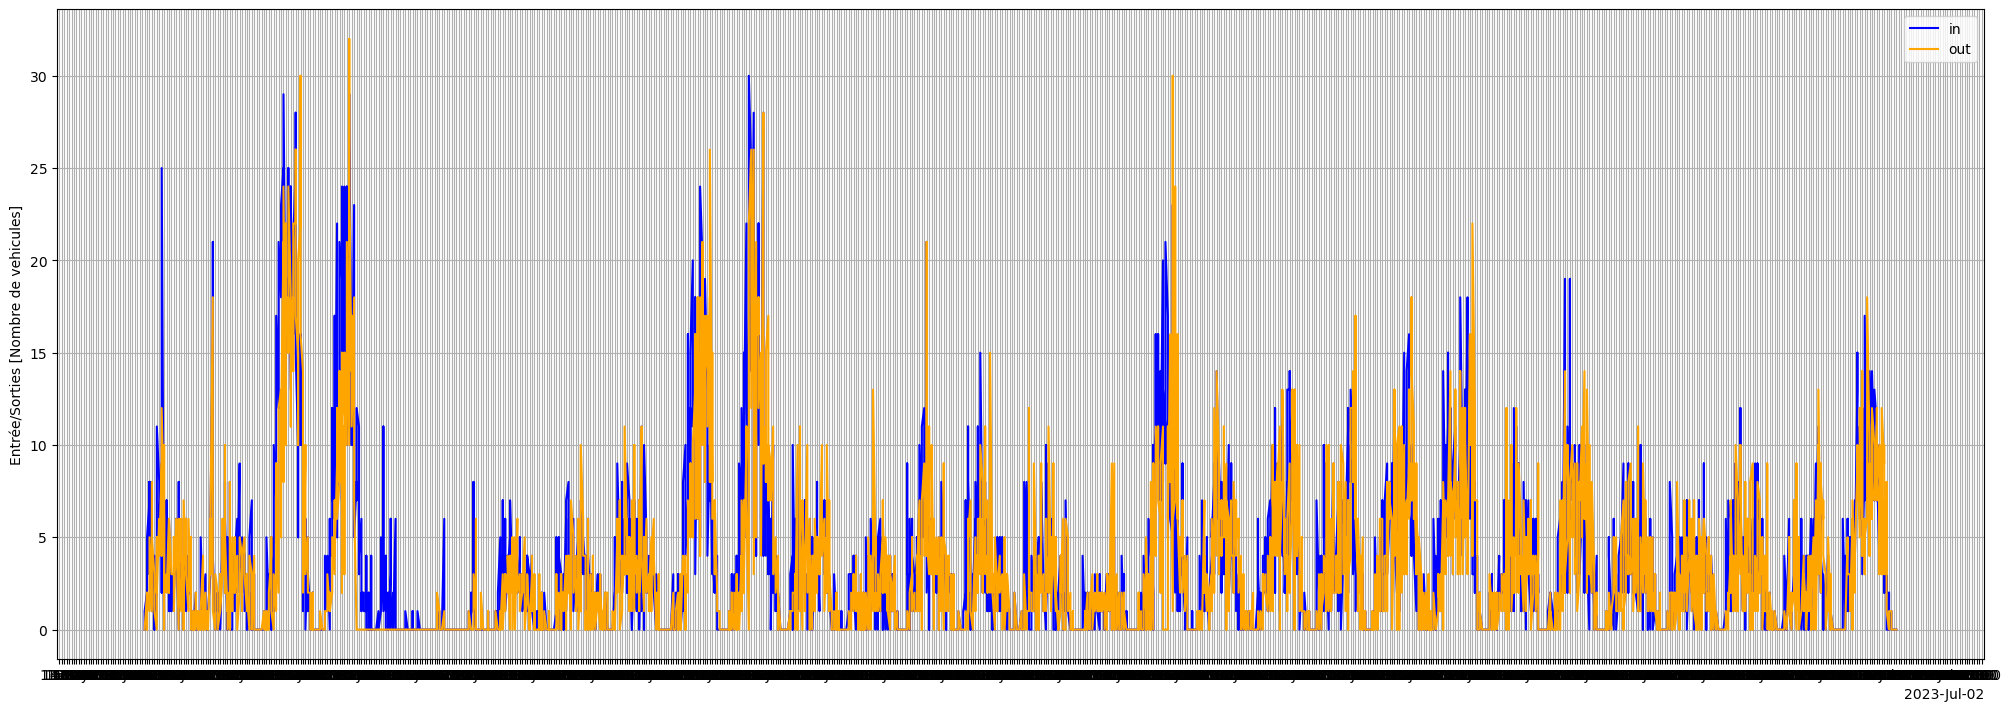

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7), constrained_layout=True)
ax.plot('timestamp', 'in', data=data, color='blue')
ax.plot('timestamp', 'out', data=data, color='orange')
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
#ax.xaxis.set_minor_locator(mdates.HourLocator(interval=12))
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True)
ax.legend()
ax.set_ylabel(r'Entrée/Sorties [Nombre de vehicules]')
fig.savefig(f'./output/entrees_sorties_horraire_du_{dt_from}_au{dt_to}.png', dpi=250)

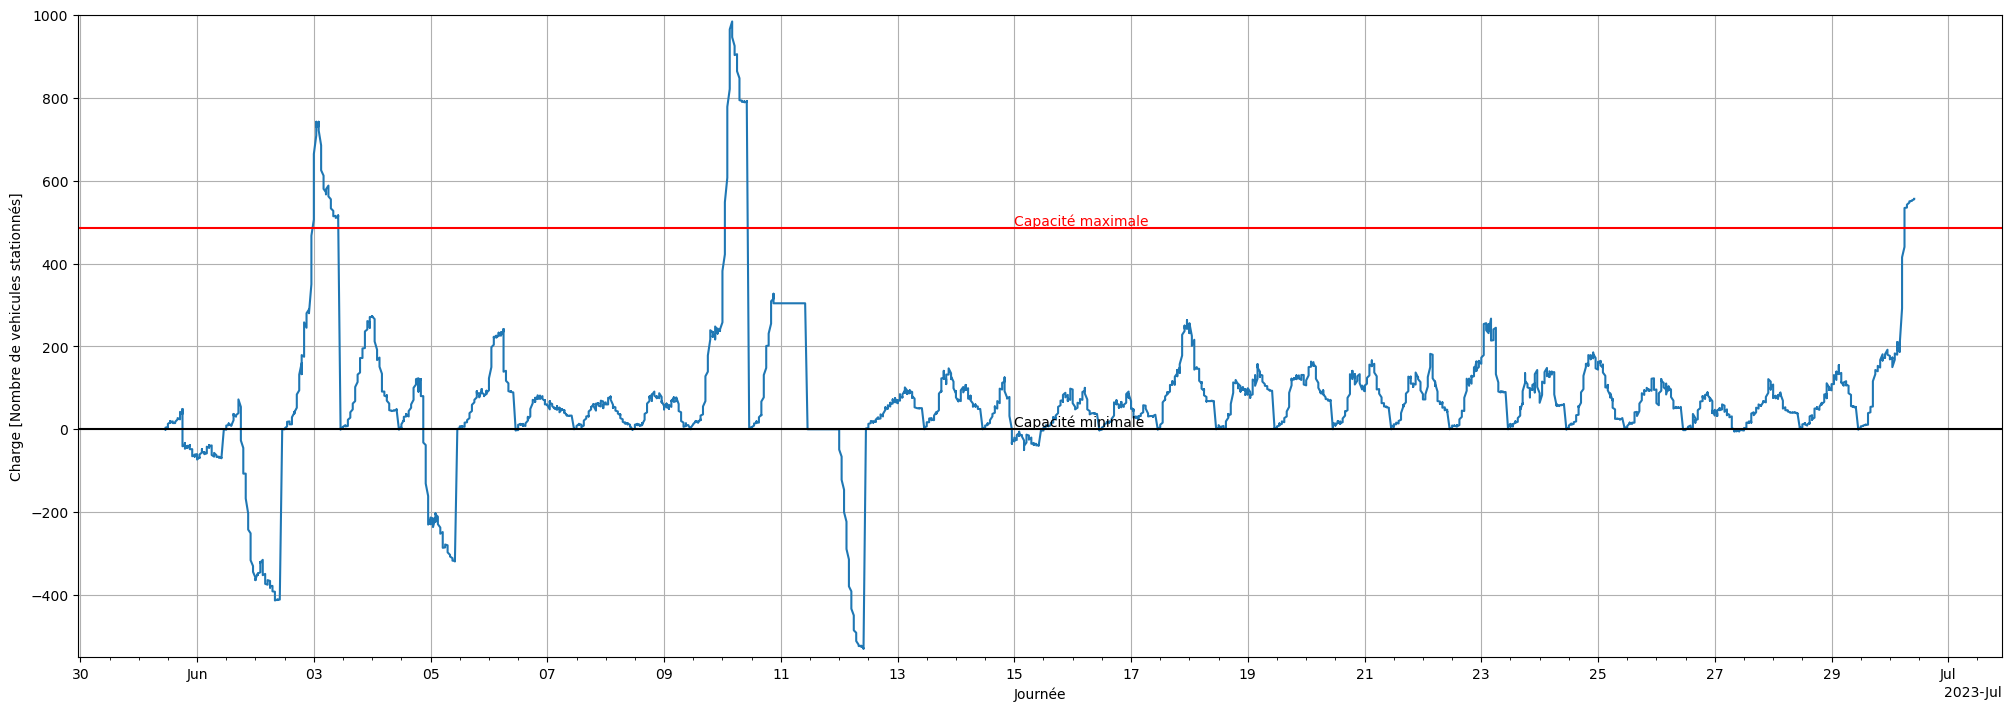

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7), constrained_layout=True)
ax.plot('timestamp', 'charge', data=data)
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.HourLocator(interval=48))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=12))
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True)
ax.set_ylabel(r'Charge [Nombre de vehicules stationnés]')
ax.set_xlabel(r'Journée')

# Capacité max
plt.axhline(y=485, color='r', linestyle='-');
t = plt.text(ax.get_xticks()[8], 485, f'Capacité maximale', fontsize=10, color='r', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# Capacité min
plt.axhline(y=0, color='k', linestyle='-');
t = plt.text(ax.get_xticks()[8], 0, f'Capacité minimale', fontsize=10, color='k', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
ax.set_ylim(-550, 1000)

fig.savefig(f'./output/distribution_charge_par_heure_{dt_from}_au_{dt_to}.png', dpi=150)

In [ ]:
print(f"{np.round(np.count_nonzero((data.charge > 425) | (data.charge < 0)) / data.shape[0] * 100)}% des charges horraire sortent de la charge possible dans le stationnement.")

61.0% des charges horraire sortent de la charge possible dans le stationnement.


### Correction for payement rate

In [ ]:
correction = np.abs(ct_in_out[dt_from:dt_to].delta.min())
corr_ax = np.zeros(ct_in_out.shape[0])
corr_ax[0] = correction
ct_in_out['delta_cor'] = ct_in_out.delta + corr_ax
ct_in_out['nb_veh_cor'] = ct_in_out.delta_cor.cumsum()

In [ ]:
ct_in_out.loc['2022-11-09']

,in,out,delta,nb_veh,delta_cor,nb_veh_cor
hr,,,,,,
11,129.0,115.0,14.0,14.0,128.0,128.0
12,51.0,46.0,5.0,19.0,5.0,133.0
13,55.0,60.0,-5.0,14.0,-5.0,128.0
14,44.0,62.0,-18.0,-4.0,-18.0,110.0
15,64.0,85.0,-21.0,-25.0,-21.0,89.0
16,47.0,76.0,-29.0,-54.0,-29.0,60.0
17,22.0,38.0,-16.0,-70.0,-16.0,44.0
18,20.0,21.0,-1.0,-71.0,-1.0,43.0
19,36.0,23.0,13.0,-58.0,13.0,56.0
